# Proyecto final
## Analisis de los datos

Loading libraries

In [2]:
from scipy import stats
from sklearn import datasets
import numpy as np
import pandas as pd 
import math
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import string

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

import time

from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn import datasets

from scipy import stats
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

we read the database

In [3]:
data_set = pd.read_csv('problem1.csv',sep=',',header='infer') 
db = data_set.copy()

In [4]:
data_set.head()

,X_training,Y_training,X_test,Y_test
0,-2.00,22.067387,2.00,6.024049
1,-1.97,19.944915,2.05,6.885408
2,-1.94,18.062490,2.10,7.578968
3,-1.91,16.384313,2.15,8.439467
4,-1.88,14.567798,2.20,9.554611


split the data

In [5]:
x_train = db.loc[:,'X_training']
y_train = db.loc[:,'Y_training']
x_test = db.loc[:,'X_test']
y_test = db.loc[:,'Y_test']

show dataframe statistics description

In [6]:
data = db.describe()
#data.pop('MPG')
data = data.transpose
data

<bound method DataFrame.transpose of        X_training  Y_training     X_test     Y_test
count  134.000000  134.000000  21.000000  21.000000
mean    -0.005000    4.467058   2.500000  24.051462
std      1.164796    4.725730   0.310242  15.829402
min     -2.000000   -3.215449   2.000000   6.024049
25%     -1.002500    1.025247   2.250000  10.845279
50%     -0.005000    4.939851   2.500000  19.726772
75%      0.992500    7.447520   2.750000  34.523070
max      1.990000   22.067387   3.000000  57.061905>

We observe that the mean values from X_training and Y_traing are far away;  -0.005000 and 4.467058. But the standard deviation show that the confidence interval of each is not disjoint of the other, so we can decide not to standarize the data.

Then we prepare the data for the grade of polynomial we want to predict

In [7]:
X_test_sin_na = pd.DataFrame(x_test).dropna()
Y_test_sin_na = pd.DataFrame(y_test).dropna()

#matriz para el polinomio
pol_data_train = {}
pol_data_test = {}
alphabet_string = string.ascii_lowercase
gr = input('What grade of polynomial do you want?\n')

gr = int(gr)
for a in range(1,gr+1,1):
    no = alphabet_string[a-1]
    train = {no : x_train**a }
    test = {no : x_test**a }
    pol_data_train.update(train)
    pol_data_test.update(test)
    
    
#pol_data_test
pol_train = pd.DataFrame.from_dict(pol_data_train , orient='columns')
pol_test = pd.DataFrame.from_dict(pol_data_test , orient='columns').dropna()



What grade of polynomial do you want?
4


## Regresiones
### Modelo Lasso
We prepare lasso model

In [8]:
alphalm = input('What alpha parameter do you want?\n')
while True:
    try:
        alph1 = float(alphalm)
        print('The Lasso model with parameter',alph1,'is:')
        break
    except:
        print('The alpha must be a number.')
        alphalm = input('What alpha parameter do you want?\n')
        
        
lm = Lasso(alpha=float(alphalm), max_iter=1e6)
lm.fit(pol_train, y_train)
salida = pd.DataFrame(lm.predict(pol_test))
salida.head()

What alpha parameter do you want?

The alpha must be a number.
What alpha parameter do you want?
.0001
The Lasso model with parameter 0.0001 is:


,0
0,5.957026
1,6.609291
2,7.390683
3,8.311369
4,9.381812


In [9]:
print('Los coeficientes del polinomio son: \n')
for b in range(0,len(lm.coef_)):
    print(lm.coef_[b])

Los coeficientes del polinomio son: 

8.028985437535216
-5.9893485449210875
-3.008486590766806
1.9953287914164473


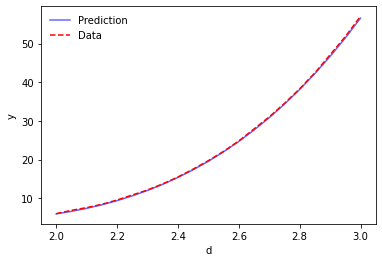

In [10]:
plt.plot(pol_test.a, salida,'b', alpha=.6 , label='Prediction')
plt.plot(pol_test.a, pd.DataFrame(y_test).dropna() ,'r--', label='Data')
plt.legend(loc='best', frameon=False)
plt.xlabel(no)
plt.ylabel('y')
plt.show()

### Model Selection
We will explore different polynomials and check which provides the best fitting as well as the least AIC.

Text(0.5, 1.0, 'Information-criterion for model selection (training time 0.025s)')

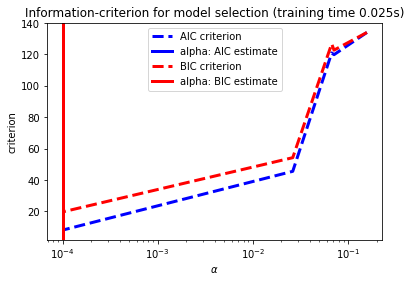

In [11]:
# This is to avoid division by zero while doing np.log10
EPSILON = 1e-4

# LassoLarsIC: least angle regression with BIC/AIC criterion

model_bic = LassoLarsIC(criterion='bic')
t1 = time.time()
model_bic.fit(pol_train, y_train)
t_bic = time.time() - t1
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(pol_train, y_train)
alpha_aic_ = model_aic.alpha_


def plot_ic_criterion(model, name, color):
    criterion_ = model.criterion_
    plt.semilogx(model.alphas_ + EPSILON, criterion_, '--', color=color,
                 linewidth=3, label='%s criterion' % name)
    plt.axvline(model.alpha_ + EPSILON, color=color, linewidth=3,
                label='alpha: %s estimate' % name)
    plt.xlabel(r'$\alpha$')
    plt.ylabel('criterion')


plt.figure()
plot_ic_criterion(model_aic, 'AIC', 'b')
plot_ic_criterion(model_bic, 'BIC', 'r')
plt.legend()
plt.title('Information-criterion for model selection (training time %.3fs)'
          % t_bic)

Computing regularization path using the coordinate descent lasso...


(0.0, 40.0)

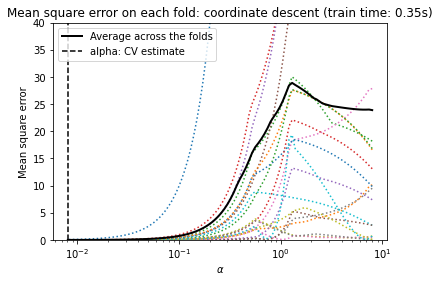

In [12]:
# LassoCV: coordinate descent

# Compute paths
print("Computing regularization path using the coordinate descent lasso...")
t1 = time.time()
model = LassoCV(cv=20).fit(pol_train, y_train)
t_lasso_cv = time.time() - t1

# Display results
plt.figure()
ymin, ymax = 0, 40
plt.semilogx(model.alphas_ + EPSILON, model.mse_path_, ':')
plt.plot(model.alphas_ + EPSILON, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(model.alpha_ + EPSILON, linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel(r'$\alpha$')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent '
          '(train time: %.2fs)' % t_lasso_cv)
plt.axis('tight')
plt.ylim(ymin, ymax)


Computing regularization path using the Lars lasso...


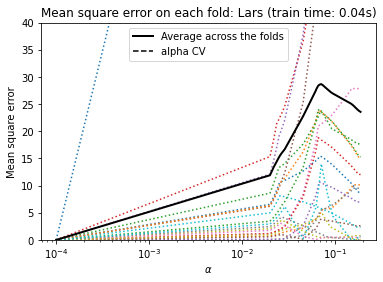

In [13]:
# LassoLarsCV: least angle regression

# Compute paths
print("Computing regularization path using the Lars lasso...")
t1 = time.time()
model = LassoLarsCV(cv=20).fit(pol_train, y_train)
t_lasso_lars_cv = time.time() - t1

# Display results
plt.figure()
plt.semilogx(model.cv_alphas_ + EPSILON, model.mse_path_, ':')
plt.semilogx(model.cv_alphas_ + EPSILON, model.mse_path_.mean(axis=-1), 'k',
             label='Average across the folds', linewidth=2)
plt.axvline(model.alpha_, linestyle='--', color='k',
            label='alpha CV')
plt.legend()

plt.xlabel(r'$\alpha$')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: Lars (train time: %.2fs)'
          % t_lasso_lars_cv)
plt.axis('tight')
plt.ylim(ymin, ymax)

plt.show()

In [16]:
degrees = np.arange(0, 1,.001)
cv_model = GridSearchCV(lm,
                        param_grid={'alpha': degrees},
                        scoring='neg_mean_squared_error')
cv_model.fit(pol_test, Y_test_sin_na);

/Users/Octavalo/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/Octavalo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/Octavalo/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/Octavalo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is disc

In [17]:
#for param in lm.get_params().keys():
#    print(param)
cv_model.best_params_, cv_model.best_estimator_.coef_

({'alpha': 0.005},
 array([-0.00000000e+00, -9.35342869e+00, -7.42108378e-03,  1.50116201e+00]))

In [ ]:
##